# Tutorial: Neural Networks using Keras


In this tutorial, you will work with a neural network on a subset of the Toronto Faces Dataset (TFD). You will use the neural network to determine when any of the faces fall into one of seven categories:

**1-Anger, 2-Disgust, 3-Fear, 4-Happy, 5-Sad, 6-Surprise, 7-Neutral**.

The data contains 3374 faces, 419 and 385 grayscale images as the training, validation and testing set respectively. The faces have been rotated, scaled, and aligned to make the task easier. Each image is of size $48 \times 48$ and containes a face that has been extracted from a variety of sources.

An example is shown below:

<center><img src="https://raw.githubusercontent.com/manchuran/introToML/master/example_face.png" width="700" height="100" class="center"></img></center>

## Part 1: Load the Toronto Faces Dataset (TFD)
Firstly, we load the data. The dataset has been prepared for you and is a `.npz` file. Run the code chunk below to load it


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

2024-03-23 23:19:39.808141: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 23:19:39.810884: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 23:19:39.841621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 23:19:39.841654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 23:19:39.842468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
! wget "https://github.com/manchuran/introToML/raw/master/toronto_face.npz"

--2024-03-23 23:19:42--  https://github.com/manchuran/introToML/raw/master/toronto_face.npz
Resolving github.com (github.com)... 

/opt/conda/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/manchuran/introToML/master/toronto_face.npz [following]
--2024-03-23 23:19:42--  https://raw.githubusercontent.com/manchuran/introToML/master/toronto_face.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12375556 (12M) [application/octet-stream]
Saving to: ‘toronto_face.npz.1’

toronto_face.npz.1  100%[===================>]  11.80M  --.-KB/s    in 0.02s   

2024-03-23 23:19:42 (478 MB/s) - ‘toronto_face.npz.1’ saved [12375556/12375556]



In [4]:
## Use numpy to load in data and obtain train, test, and validation sets

with np.load("toronto_face.npz") as npzfile:
  inputs_train = npzfile["inputs_train"] / 255.0 #normalize input data
  inputs_valid = npzfile["inputs_valid"] / 255.0
  inputs_test = npzfile["inputs_test"] / 255.0
  target_train = npzfile["target_train"]
  target_valid = npzfile["target_valid"]
  target_test = npzfile["target_test"]


In [5]:
# Prepare labels
# Note that to confirm with Python's 0-indexing, we have relabeled Anger to 0, Digust to 1, etc.

target_labels = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

Display a few random samples from the training set. 
The following code creates a 2x2 grid of subplots, each displaying an image from the inputs_train dataset.

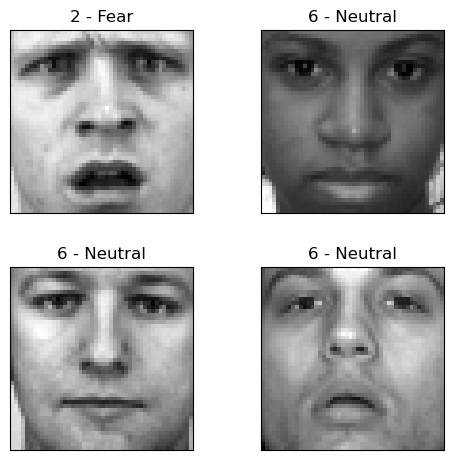

In [6]:
# Set the desired image size (48x48 pixels)
img_size = 48

# Create a 2x2 grid of subplots with a specified figure size
fig, ax = plt.subplots(2, 2, figsize=(7, 6))

# Iterate over the 4 subplots
for i in range(4):
    # Randomly select an index from the training data
    s = np.random.choice(range(inputs_train.shape[0]))
    
    # Display the image at index 's' after reshaping it to the desired size
    ax[i // 2, i % 2].imshow(inputs_train[s, :].reshape((img_size, img_size)), cmap="gray")
    
    # Set the title of the subplot with the corresponding emotion label
    ax[i // 2, i % 2].set_title(f"{target_train[s]} - {target_labels[target_train[s]]}")
    
    # Hide x-axis and y-axis ticks
    ax[i // 2, i % 2].get_xaxis().set_visible(False)
    ax[i // 2, i % 2].get_yaxis().set_visible(False)

# Adjust spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.8, wspace=0.05, hspace=0.3)


---

Verify how many examples are in the train, validation, and test sets.

---

In [7]:
train_num = inputs_train.shape[0]
val_num = inputs_valid.shape[0]
test_num = inputs_test.shape[0]

print(f"There are {train_num} training samples, {val_num} validation samples, and {test_num} test samples")

#*************************************************************#

There are 3374 training samples, 419 validation samples, and 385 test samples


---

Verify how many classes are present in the label.

---

In [8]:
# Determine the unique values in the label
# Hint: Use np.unique to output the unique values amongst the targets, then count the classes

num_classes = len(np.unique(target_train))

print(f"There are {num_classes} classes in this labelled dataset")

#*************************************************************#

There are 7 classes in this labelled dataset



## Part 2: Train and Test Model

Task: Use Keras to train a classification model that predicts the correct face.

Run the code cell below. Note that each image consists of 2304 pixels. The training set contains 3374 of them.

In [9]:
# Define model parameters. These parameters are defined for you.
# Run the code cells below

input_shape = inputs_train.shape[1]
learning_rate = 0.001
EPOCHS = 100

You will use Adam optimization to conduct the gradient descent. Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

Run the code cell below

In [10]:
# Create Neural Network Model

def create_model(num_classes,
                 input_shape,
                 learning_rate):
    """
    Creates a neural network model for classification tasks.

    Args:
        num_classes (int): Number of output classes (target categories).
        input_shape (int): Dimensionality of input features.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        tf.keras.models.Sequential: Compiled neural network model.
    """

    # Define a sequential model
    model = tf.keras.models.Sequential([
        # First hidden layer with 64 neurons and ReLU activation
        tf.keras.layers.Dense(64, activation="relu", input_shape=(input_shape,)),
        # Second hidden layer with 128 neurons and ReLU activation
        tf.keras.layers.Dense(128, activation="relu"),
        # Third hidden layer with 256 neurons and ReLU activation
        tf.keras.layers.Dense(256, activation='relu'),
        # Output layer with 'num_classes' neurons and softmax activation
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [11]:
# Get untrained model. Run this code cell
model = create_model(num_classes,
                     input_shape,
                     learning_rate)

# Train the model
history = model.fit(inputs_train, target_train,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(inputs_valid, target_valid))

Epoch 1/100
106/106 [==============================] - 1s 4ms/step - loss: 1.7188 - accuracy: 0.3435 - val_loss: 1.4825 - val_accuracy: 0.4248
Epoch 2/100
106/106 [==============================] - 0s 2ms/step - loss: 1.3516 - accuracy: 0.5178 - val_loss: 1.3139 - val_accuracy: 0.4940
Epoch 3/100
106/106 [==============================] - 0s 2ms/step - loss: 1.2656 - accuracy: 0.5453 - val_loss: 1.1338 - val_accuracy: 0.5752
Epoch 4/100
106/106 [==============================] - 0s 2ms/step - loss: 1.2310 - accuracy: 0.5516 - val_loss: 1.1912 - val_accuracy: 0.5919
Epoch 5/100
106/106 [==============================] - 0s 2ms/step - loss: 1.1039 - accuracy: 0.5999 - val_loss: 1.2718 - val_accuracy: 0.5227
Epoch 6/100
106/106 [==============================] - 0s 2ms/step - loss: 1.1085 - accuracy: 0.5999 - val_loss: 1.2200 - val_accuracy: 0.5609
Epoch 7/100
106/106 [==============================] - 0s 2ms/step - loss: 1.0562 - accuracy: 0.6067 - val_loss: 0.9702 - val_accuracy: 0.6444

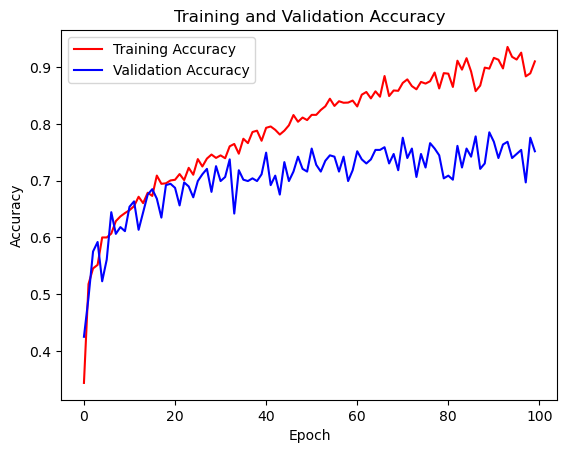

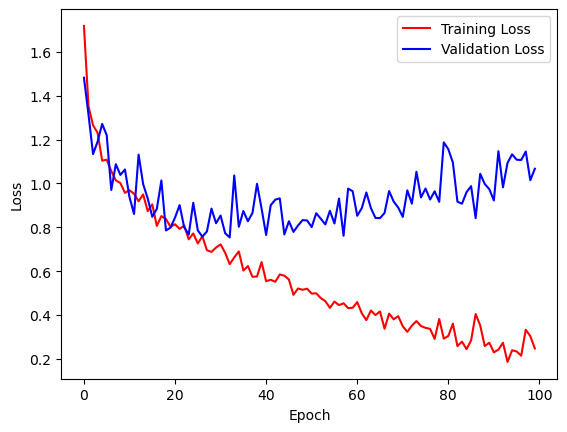

In [12]:
#-----------------------------------------------------------
# Retrieve results on training and validation datasets for each training epoch
#-----------------------------------------------------------
# Extract training accuracy, validation accuracy, training loss, and validation loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the total number of epochs
epochs = range(len(acc))

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")  # Plot training accuracy in red
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")  # Plot validation accuracy in blue
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()  # Display legend
plt.show()  # Show the plot
print("")  # Print an empty line

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")  # Plot training loss in red
plt.plot(epochs, val_loss, 'b', label="Validation Loss")  # Plot validation loss in blue
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()  # Display legend
plt.show()  # Show the plot


---

**Problem**

What do you observe about the training loss and validation loss using the default learning rate of $10^{-3}$?


$\color{red}{\textit Your Answer:}$



---

**Problem**

Using the function [`model.predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), carry out predictions on the test set.

---

In [13]:
#****************YOUR CODE HERE (Problem 2.2) ****************#

predicted_ytest = model.predict(inputs_test)

#*************************************************************#

13/13 [==============================] - 0s 1ms/step


The results are probabilities which, for each test sample, provides the probability of being any of the 7 classes. The most probable class has the highest probability.

You can visualize this for the first 16 samples using a barplot.

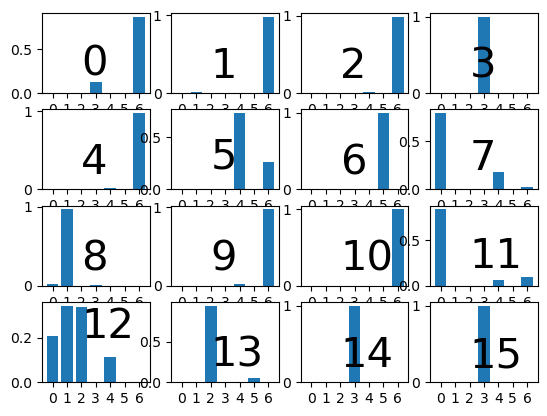

In [14]:
h =4
m = n = h
labels = list(range(7))
u=m*n
plotted_predicted_test = predicted_ytest[:u, :]
fig, ax = plt.subplots(m,n)
for i, j in enumerate(range(m*n)):
  ax[i//m, i%n].bar(labels, plotted_predicted_test[j, :])
  ax[i//m, i%n].set_xticks(list(range(7)))
  ax[i//m, i%n].text(2, 0.2,str(j), fontsize=30)
plt.show()

This means for the first test sample (`sample 0 `), the most probable output is the class with the longest bar. The sample applies for every other prediction.

Next you need to convert these probabilities to the required classes.

You use $$\hat c_{pred} = \arg \max \hat y$$

---

**Problem**

Find the predicted class for each test sample using the result, `predicted_ytest`, from above and print out the first 10 results from your prediction. Use [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) to do this. Don't forget to set the right value for the axis parameter!  

“axis 0” represents rows and “axis 1” represents columns.

---

In [15]:


predicted_test = np.argmax(predicted_ytest, axis=1)

#*************************************************************#

In [16]:
# Print out the predicted labels for the first 10 examples in the test set
predicted_test[:10]

array([6, 6, 6, 3, 6, 4, 5, 0, 1, 6])

Having obtained your prediction, you may now see the summary of this model that produced this output. The model summary is shown below. This model summary provides an outline of the neural network model. In the first layer, we have 64 units. In the second, we have 128 units, and in the third we have 512 units. The output layer has 7 units because we have 7 classes in the output label.

In [17]:
# See the model summary. Run this code cell
model.summary()
48*48*64 + 64

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                147520    
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 190663 (744.78 KB)
Trainable params: 190663 (744.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


147520

In [18]:
# You can also obtain the weights obtained for each layer as discussed in class
weights = [layer.get_weights() for layer in model.layers]

For the first layer, we can obtain the weights as below

The weights of layer 0 have shape (2304, 64)



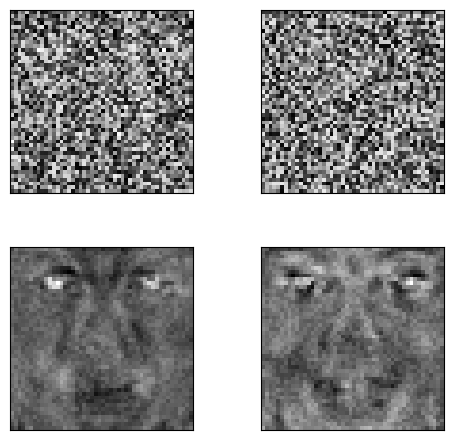

In [19]:
# Set the layer index (e.g., layer 0)
layer = 0

# Print information about the weights of the specified layer
print(f"The weights of layer {layer} have shape {weights[layer][0].shape}")
print()

# Set the desired image size (48x48 pixels)
img_size = 48

# Create a 2x2 grid of subplots with a specified figure size
fig, ax = plt.subplots(2, 2, figsize=(7, 6))

# Iterate over the 4 subplots
for i in range(4):
    # Randomly select an index 's' from the weights of the specified layer
    s = np.random.choice(range(weights[layer][0].shape[1]))
    
    # Display the weight vector at index 's' after reshaping it to the desired size
    ax[i // 2, i % 2].imshow(weights[layer][0][:, s].reshape((img_size, img_size)), cmap="gray")
    
    # Hide x-axis and y-axis ticks
    ax[i // 2, i % 2].get_xaxis().set_visible(False)
    ax[i // 2, i % 2].get_yaxis().set_visible(False)

# Adjust spacing between subplots
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.8, wspace=0.05, hspace=0.3)


The weights of the first layer has shape $2304 \times 64$ because the layer has 64 units and the input data has 2304 features. **You can change the value of `layer` to see the weights of other layers in the network.**

---



---

**Problem**

Find the accuracy of the model using the test data.

---

In [20]:
# Calculate the accuracy

accuracy_value = np.mean(predicted_test == target_test)
print(f"Test Accuracy = {accuracy_value}")  # returns the fraction of test data classified correctly

#*************************************************************#

Test Accuracy = 0.7142857142857143


## Part 3: Modify Model and Tune Learning Rate

A model's learning rate can be one of the most important parameters which could help with effective optimization via gradient descent.

To find this optimally, you can use a learning rate scheduler in `Keras`. This is a part of machine learning called hyperparameter tuning and is essential to obtaining a good model.

In [21]:
# Run the code cells below

def adjust_learning_rate(num_classes,
                        input_shape,
                        learning_rate):

    model = create_model(num_classes,
                 input_shape,
                 learning_rate)

    # Select your optimizer
    optimizer = tf.keras.optimizers.Adam()

    # Compile the model passing in the appropriate loss
    model.compile(optimizer=optimizer,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

    #history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    return model

In [22]:
# Get untrained model
model = adjust_learning_rate(num_classes,
                     input_shape,
                     learning_rate)

# Train the model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
history = model.fit(inputs_train, target_train,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[lr_schedule],
                    validation_data=(inputs_valid, target_valid))

Epoch 1/100
106/106 [==============================] - 1s 3ms/step - loss: 1.9075 - accuracy: 0.2018 - val_loss: 1.8956 - val_accuracy: 0.2530 - lr: 1.0000e-06
Epoch 2/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8885 - accuracy: 0.2774 - val_loss: 1.8809 - val_accuracy: 0.2888 - lr: 1.1220e-06
Epoch 3/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8726 - accuracy: 0.2949 - val_loss: 1.8683 - val_accuracy: 0.2840 - lr: 1.2589e-06
Epoch 4/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8593 - accuracy: 0.2869 - val_loss: 1.8580 - val_accuracy: 0.2792 - lr: 1.4125e-06
Epoch 5/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8499 - accuracy: 0.2854 - val_loss: 1.8507 - val_accuracy: 0.2792 - lr: 1.5849e-06
Epoch 6/100
106/106 [==============================] - 0s 2ms/step - loss: 1.8432 - accuracy: 0.2854 - val_loss: 1.8453 - val_accuracy: 0.2792 - lr: 1.7783e-06
Epoch 7/100
106/106 [===================

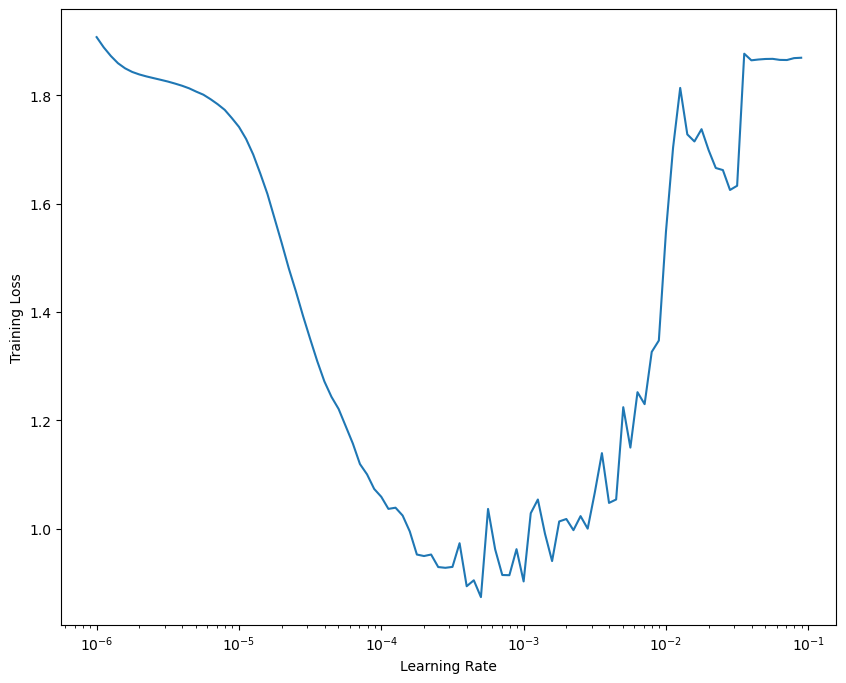

In [23]:
# Plot the loss against LR
plt.figure(figsize=(10,8))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Training Loss")
plt.show()

---

**Problem**

What do you observe about this plot of `training_loss` against `learning_rate`?

---

$\color{red}{\textit Your Answer:}$




---





Obtain the learning rate resulting in the smallest loss.
However, we do not directly choose this value because the loss is not stable there.
Instead, we choose some distance before where the loss is more stable.  In this case, we have chosen a learning_rate of 0.0002.


Retrain your model with the new learning rate.


In [24]:
learning_rate = 2e-4 # new learning rate

# Retrain model
# Get untrained model
model = create_model(num_classes,
                     input_shape,
                     learning_rate)

# Train the model
history = model.fit(inputs_train, target_train,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(inputs_valid, target_valid))


Epoch 1/100
106/106 [==============================] - 1s 3ms/step - loss: 1.8037 - accuracy: 0.3094 - val_loss: 1.6992 - val_accuracy: 0.4296
Epoch 2/100
106/106 [==============================] - 0s 3ms/step - loss: 1.6077 - accuracy: 0.4265 - val_loss: 1.4937 - val_accuracy: 0.4726
Epoch 3/100
106/106 [==============================] - 0s 2ms/step - loss: 1.4324 - accuracy: 0.4905 - val_loss: 1.3472 - val_accuracy: 0.5107
Epoch 4/100
106/106 [==============================] - 0s 2ms/step - loss: 1.3183 - accuracy: 0.5406 - val_loss: 1.2550 - val_accuracy: 0.5346
Epoch 5/100
106/106 [==============================] - 0s 2ms/step - loss: 1.2545 - accuracy: 0.5528 - val_loss: 1.2762 - val_accuracy: 0.5322
Epoch 6/100
106/106 [==============================] - 0s 3ms/step - loss: 1.1778 - accuracy: 0.5848 - val_loss: 1.1318 - val_accuracy: 0.5752
Epoch 7/100
106/106 [==============================] - 0s 2ms/step - loss: 1.1202 - accuracy: 0.6043 - val_loss: 1.1296 - val_accuracy: 0.5990



Use `model.predict` again and obtain the accuracy value for the learning rate you have chosen.


In [27]:
from sklearn.metrics import accuracy_score

# Conduct prediction using new model
predicted_ytest = model.predict(inputs_test)
predicted_test = np.argmax(predicted_ytest, axis=1)

# Print out the new accuracy percentage
accuracy_value = accuracy_score(predicted_test, target_test) * 100
print(f"Test Accuracy = {accuracy_value}")

13/13 [==============================] - 0s 1ms/step
Test Accuracy = 76.1038961038961


---

**Problem**

How does this compare to the accuracy level for the model created in Problem 2 using a learning rate of 0.001? How do you think choosing the learning rate impacts your model?

---

$\color{red}{\textit Your Answer:}$


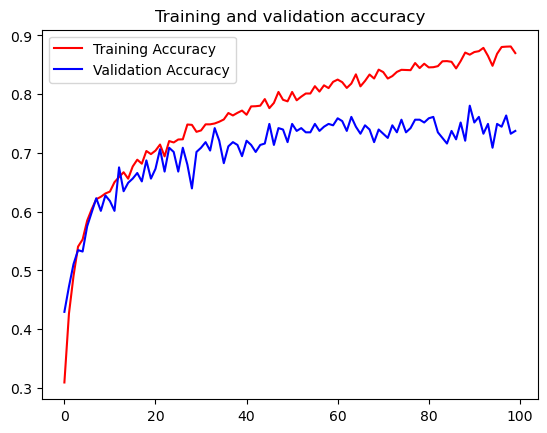

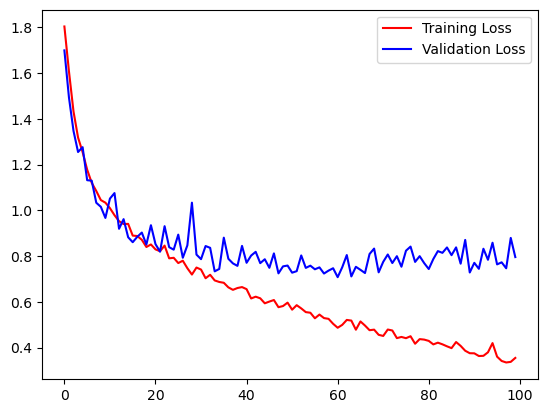

In [28]:
#-----------------------------------------------------------
# Retrieve results on training and validation datasets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend()
plt.show()